In [1]:
import os
import numpy as np
import torch
import time

/home/tony/miniconda3/envs/atsp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch.utils.data import DataLoader
from generate_data import generate_vrp_data
from utils import load_model
from problems import CVRP

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Code inspired by Google OR Tools plot:
# https://github.com/google/or-tools/blob/fb12c5ded7423d524fc6c95656a9bdc290a81d4d/examples/python/cvrptw_plot.py

def discrete_cmap(N, base_cmap=None):
  """
    Create an N-bin discrete colormap from the specified input map
    """
  # Note that if base_cmap is a string or None, you can simply do
  #    return plt.cm.get_cmap(base_cmap, N)
  # The following works for string, None, or a colormap instance:

  base = plt.cm.get_cmap(base_cmap)
  color_list = base(np.linspace(0, 1, N))
  cmap_name = base.name + str(N)
  return base.from_list(cmap_name, color_list, N)

def plot_vehicle_routes(data, route, ax1, markersize=5, visualize_demands=False, demand_scale=1, round_demand=False):
    """
    Plot the vehicle routes on matplotlib axis ax1.
    """
    
    # route is one sequence, separating different routes with 0 (depot)
    routes = [r[r!=0] for r in np.split(route.cpu().numpy(), np.where(route==0)[0]) if (r != 0).any()]
    depot = data['depot'].cpu().numpy()
    locs = data['loc'].cpu().numpy()
    demands = data['demand'].cpu().numpy() * demand_scale
    capacity = demand_scale # Capacity is always 1
    
    x_dep, y_dep = depot
    ax1.plot(x_dep, y_dep, 'sk', markersize=markersize*4)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    legend = ax1.legend(loc='upper center')
    
    cmap = discrete_cmap(len(routes) + 2, 'nipy_spectral')
    dem_rects = []
    used_rects = []
    cap_rects = []
    qvs = []
    total_dist = 0
    route_dist = []
    for veh_number, r in enumerate(routes):
        color = cmap(len(routes) - veh_number) # Invert to have in rainbow order
        
        route_demands = demands[r - 1]
        coords = locs[r - 1, :]
        xs, ys = coords.transpose()

        total_route_demand = sum(route_demands)
        # assert total_route_demand <= capacity
        if not visualize_demands:
            ax1.plot(xs, ys, 'o', mfc=color, markersize=markersize, markeredgewidth=0.0)
        
        dist = 0
        x_prev, y_prev = x_dep, y_dep
        cum_demand = 0
        for (x, y), d in zip(coords, route_demands):
            dist += np.sqrt((x - x_prev) ** 2 + (y - y_prev) ** 2)
            
            cap_rects.append(Rectangle((x, y), 0.01, 0.1))
            used_rects.append(Rectangle((x, y), 0.01, 0.1 * total_route_demand / capacity))
            dem_rects.append(Rectangle((x, y + 0.1 * cum_demand / capacity), 0.01, 0.1 * d / capacity))
            
            x_prev, y_prev = x, y
            cum_demand += d
            
        dist += np.sqrt((x_dep - x_prev) ** 2 + (y_dep - y_prev) ** 2)
        total_dist += dist
        route_dist.append(dist)
        qv = ax1.quiver(
            xs[:-1],
            ys[:-1],
            xs[1:] - xs[:-1],
            ys[1:] - ys[:-1],
            scale_units='xy',
            angles='xy',
            scale=1,
            color=color,
            label='R{}, # {}, d {:.2f}'.format(
                veh_number, 
                len(r), 
                dist
            )
        )
        
        qvs.append(qv)
        
    ax1.set_title('{} routes, total distance {:.2f}'.format(len(routes), total_dist))
    ax1.legend(handles=qvs)
    
    pc_cap = PatchCollection(cap_rects, facecolor='whitesmoke', alpha=1.0, edgecolor='lightgray')
    pc_used = PatchCollection(used_rects, facecolor='lightgray', alpha=1.0, edgecolor='lightgray')
    pc_dem = PatchCollection(dem_rects, facecolor='black', alpha=1.0, edgecolor='black')
    
    if visualize_demands:
        ax1.add_collection(pc_cap)
        ax1.add_collection(pc_used)
        ax1.add_collection(pc_dem)

    return routes, route_dist, total_dist

In [4]:
def plot_HPP_routes(data, route, ax1, markersize=5, visualize_demands=False, demand_scale=1, round_demand=False):
    """
    Plot the vehicle routes on matplotlib axis ax1.
    """

    # route is one sequence, separating different routes with 0 (depot)
    routes = [r[r!=0] for r in np.split(route.cpu().numpy(), np.where(route==0)[0]) if (r != 0).any()]
    depot = data['depot'].cpu().numpy()
    locs = data['loc'].cpu().numpy()
    # demands = data['demand'].cpu().numpy() * demand_scale
    # capacity = demand_scale # Capacity is always 1
    
    x_dep, y_dep = depot
    ax1.plot(x_dep, y_dep, 'sk', markersize=markersize*4)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    legend = ax1.legend(loc='upper center')
    
    cmap = discrete_cmap(len(routes) + 2, 'nipy_spectral')
    dem_rects = []
    used_rects = []
    # cap_rects = []
    qvs = []
    total_dist = 0
    route_dist = []
    for veh_number, r in enumerate(routes):
        color = cmap(len(routes) - veh_number) # Invert to have in rainbow order
        
        # route_demands = demands[r - 1]
        coords = locs[r - 1, :]
        xs, ys = coords.transpose()

        # total_route_demand = sum(route_demands)
        # assert total_route_demand <= capacity
        if not visualize_demands:
            ax1.plot(xs, ys, 'o', mfc=color, markersize=markersize, markeredgewidth=0.0)
        
        dist = 0
        x_prev, y_prev = x_dep, y_dep
        cum_demand = 0
        for (x, y) in coords:
            dist += np.sqrt((x - x_prev) ** 2 + (y - y_prev) ** 2)
            
            # cap_rects.append(Rectangle((x, y), 0.01, 0.1))
            # used_rects.append(Rectangle((x, y), 0.01, 0.1 * total_route_demand / capacity))
            # dem_rects.append(Rectangle((x, y + 0.1 * cum_demand / capacity), 0.01, 0.1 * d / capacity))
            
            x_prev, y_prev = x, y
            # cum_demand += d
            
        dist += np.sqrt((x_dep - x_prev) ** 2 + (y_dep - y_prev) ** 2)
        total_dist += dist
        route_dist.append(dist)
        qv = ax1.quiver(
            xs[:-1],
            ys[:-1],
            xs[1:] - xs[:-1],
            ys[1:] - ys[:-1],
            scale_units='xy',
            angles='xy',
            scale=1,
            color=color,
            label='R{}, # {}, d {:.2f}'.format(
                veh_number, 
                len(r), 
                dist
            )
        )
        
        qvs.append(qv)
        
    ax1.set_title('{} routes, total distance {:.2f}'.format(len(routes), total_dist))
    ax1.legend(handles=qvs)
    
    # pc_cap = PatchCollection(cap_rects, facecolor='whitesmoke', alpha=1.0, edgecolor='lightgray')
    # pc_used = PatchCollection(used_rects, facecolor='lightgray', alpha=1.0, edgecolor='lightgray')
    # pc_dem = PatchCollection(dem_rects, facecolor='black', alpha=1.0, edgecolor='black')
    
    # if visualize_demands:
    #     ax1.add_collection(pc_cap)
    #     ax1.add_collection(pc_used)
    #     ax1.add_collection(pc_dem)

    return routes, route_dist, total_dist

In [5]:
def plot_GLOP_routes(data, route, ax1, markersize=5, visualize_demands=False, demand_scale=1, round_demand=False):
    """
    Plot the vehicle routes on matplotlib axis ax1.
    """

    # route is one sequence, separating different routes with 0 (depot)
    routes = [r[r!=0] for r in np.split(route.cpu().numpy(), np.where(route==0)[0]) if (r != 0).any()]
    depot = data['depot'].cpu().numpy()
    locs = data['loc'].cpu().numpy()
    # demands = data['demand'].cpu().numpy() * demand_scale
    # capacity = demand_scale # Capacity is always 1
    
    x_dep, y_dep = depot
    ax1.plot(x_dep, y_dep, 'sk', markersize=markersize*4)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    legend = ax1.legend(loc='upper center')
    
    cmap = discrete_cmap(len(routes) + 2, 'nipy_spectral')
    dem_rects = []
    used_rects = []
    # cap_rects = []
    qvs = []
    total_dist = 0
    route_dist = []
    for veh_number, r in enumerate(routes):
        color = cmap(len(routes) - veh_number) # Invert to have in rainbow order
        
        # route_demands = demands[r - 1]
        coords = locs[r - 1, :]
        xs, ys = coords.transpose()

        # total_route_demand = sum(route_demands)
        # assert total_route_demand <= capacity
        if not visualize_demands:
            ax1.plot(xs, ys, 'o', mfc=color, markersize=markersize, markeredgewidth=0.0)
        
        dist = 0
        x_prev, y_prev = x_dep, y_dep
        cum_demand = 0
        for (x, y) in coords:
            dist += np.sqrt((x - x_prev) ** 2 + (y - y_prev) ** 2)
            
            # cap_rects.append(Rectangle((x, y), 0.01, 0.1))
            # used_rects.append(Rectangle((x, y), 0.01, 0.1 * total_route_demand / capacity))
            # dem_rects.append(Rectangle((x, y + 0.1 * cum_demand / capacity), 0.01, 0.1 * d / capacity))
            
            x_prev, y_prev = x, y
            # cum_demand += d
            
        dist += np.sqrt((x_dep - x_prev) ** 2 + (y_dep - y_prev) ** 2)
        total_dist += dist
        route_dist.append(dist)
        qv = ax1.quiver(
            xs[:-1],
            ys[:-1],
            xs[1:] - xs[:-1],
            ys[1:] - ys[:-1],
            scale_units='xy',
            angles='xy',
            scale=1,
            color=color,
            label='R{}, # {}, d {:.2f}'.format(
                veh_number, 
                len(r), 
                dist
            )
        )
        
        qvs.append(qv)
        
    ax1.set_title('{} routes, total distance {:.2f}'.format(len(routes), total_dist))
    ax1.legend(handles=qvs)
    
    # pc_cap = PatchCollection(cap_rects, facecolor='whitesmoke', alpha=1.0, edgecolor='lightgray')
    # pc_used = PatchCollection(used_rects, facecolor='lightgray', alpha=1.0, edgecolor='lightgray')
    # pc_dem = PatchCollection(dem_rects, facecolor='black', alpha=1.0, edgecolor='black')
    
    # if visualize_demands:
    #     ax1.add_collection(pc_cap)
    #     ax1.add_collection(pc_used)
    #     ax1.add_collection(pc_dem)

    return routes, route_dist, total_dist

In [6]:
def solve_vehicle_routes(data, route, markersize=5, visualize_demands=False, demand_scale=1, round_demand=False):
    """
    Plot the vehicle routes on matplotlib axis ax1.
    """

    # route is one sequence, separating different routes with 0 (depot)
    routes = [r[r!=0] for r in np.split(route.cpu().numpy(), np.where(route==0)[0]) if (r != 0).any()]
    depot = data['depot'].cpu().numpy()
    locs = data['loc'].cpu().numpy()
    demands = data['demand'].cpu().numpy() * demand_scale
    capacity = demand_scale # Capacity is always 1

    x_dep, y_dep = depot
    # ax1.plot(x_dep, y_dep, 'sk', markersize=markersize*4)
    # ax1.set_xlim(0, 1)
    # ax1.set_ylim(0, 1)

    # legend = ax1.legend(loc='upper center')

    # cmap = discrete_cmap(len(routes) + 2, 'nipy_spectral')
    dem_rects = []
    used_rects = []
    cap_rects = []
    qvs = []
    total_dist = 0
    route_dist = []
    for veh_number, r in enumerate(routes):
        # color = cmap(len(routes) - veh_number) # Invert to have in rainbow order
        
        route_demands = demands[r - 1]
        coords = locs[r - 1, :]
        xs, ys = coords.transpose()

        total_route_demand = sum(route_demands)
        # assert total_route_demand <= capacity
        # if not visualize_demands:
        #     ax1.plot(xs, ys, 'o', mfc=color, markersize=markersize, markeredgewidth=0.0)
        
        dist = 0
        x_prev, y_prev = x_dep, y_dep
        cum_demand = 0
        for (x, y), d in zip(coords, route_demands):
            dist += np.sqrt((x - x_prev) ** 2 + (y - y_prev) ** 2)
            
            cap_rects.append(Rectangle((x, y), 0.01, 0.1))
            used_rects.append(Rectangle((x, y), 0.01, 0.1 * total_route_demand / capacity))
            dem_rects.append(Rectangle((x, y + 0.1 * cum_demand / capacity), 0.01, 0.1 * d / capacity))
            
            x_prev, y_prev = x, y
            cum_demand += d
            
        dist += np.sqrt((x_dep - x_prev) ** 2 + (y_dep - y_prev) ** 2)
        total_dist += dist
        route_dist.append(dist)
        # qv = ax1.quiver(
        #     xs[:-1],
        #     ys[:-1],
        #     xs[1:] - xs[:-1],
        #     ys[1:] - ys[:-1],
        #     scale_units='xy',
        #     angles='xy',
        #     scale=1,
        #     color=color,
        #     label='R{}, # {}, c {} / {}, d {:.2f}'.format(
        #         veh_number, 
        #         len(r), 
        #         int(total_route_demand) if round_demand else total_route_demand, 
        #         int(capacity) if round_demand else capacity,
        #         dist
        #     )
        # )
        
        # qvs.append(qv)
        
    # ax1.set_title('{} routes, total distance {:.2f}'.format(len(routes), total_dist))
    # ax1.legend(handles=qvs)

    # pc_cap = PatchCollection(cap_rects, facecolor='whitesmoke', alpha=1.0, edgecolor='lightgray')
    # pc_used = PatchCollection(used_rects, facecolor='lightgray', alpha=1.0, edgecolor='lightgray')
    # pc_dem = PatchCollection(dem_rects, facecolor='black', alpha=1.0, edgecolor='black')

    # if visualize_demands:
    #     ax1.add_collection(pc_cap)
    #     ax1.add_collection(pc_used)
    #     ax1.add_collection(pc_dem)

    return routes, route_dist, total_dist

In [7]:
vrp_size = 50
model, _ = load_model('/home/tony/github/attention-learn-to-route/outputs/tsp_50/atsp_50_20220818T140644/epoch-4.pt')
torch.manual_seed(1234)
# dataset = CVRP.make_dataset(filename='ATSP_ponddataset'+str(vrp_size)+'.pkl')
dataset = CVRP.make_dataset(size=50, num_samples=10)

  [*] Loading model from /home/tony/github/attention-learn-to-route/outputs/tsp_50/atsp_50_20220818T140644/epoch-4.pt


/home/tony/github/HAUCS/haucs/data/dataset.py:86: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  loc = [(pt.x, pt.y) for pt in MP]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

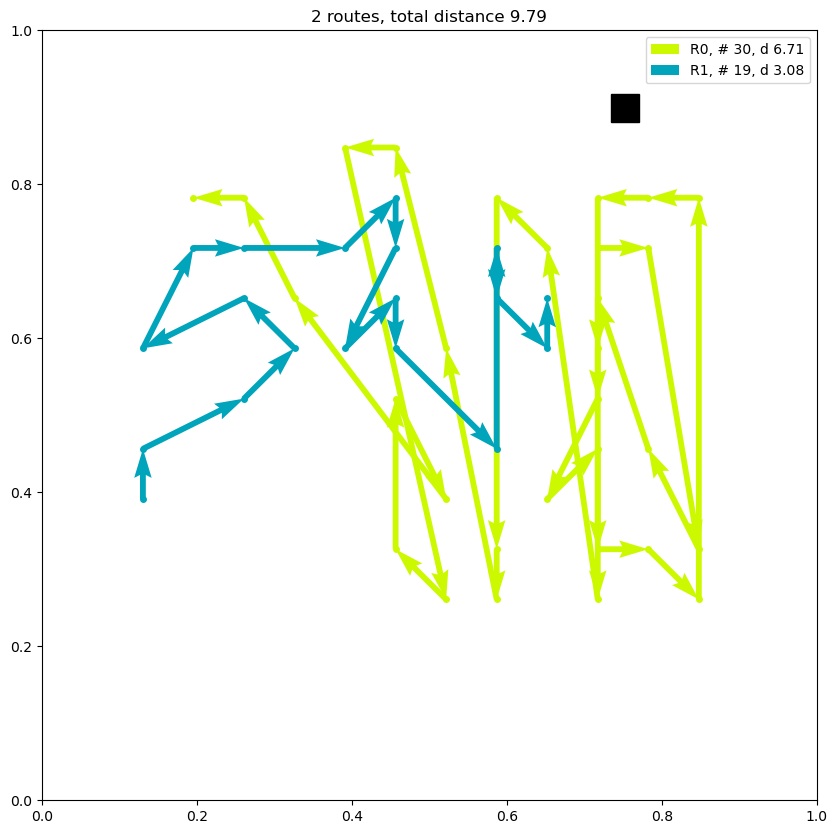

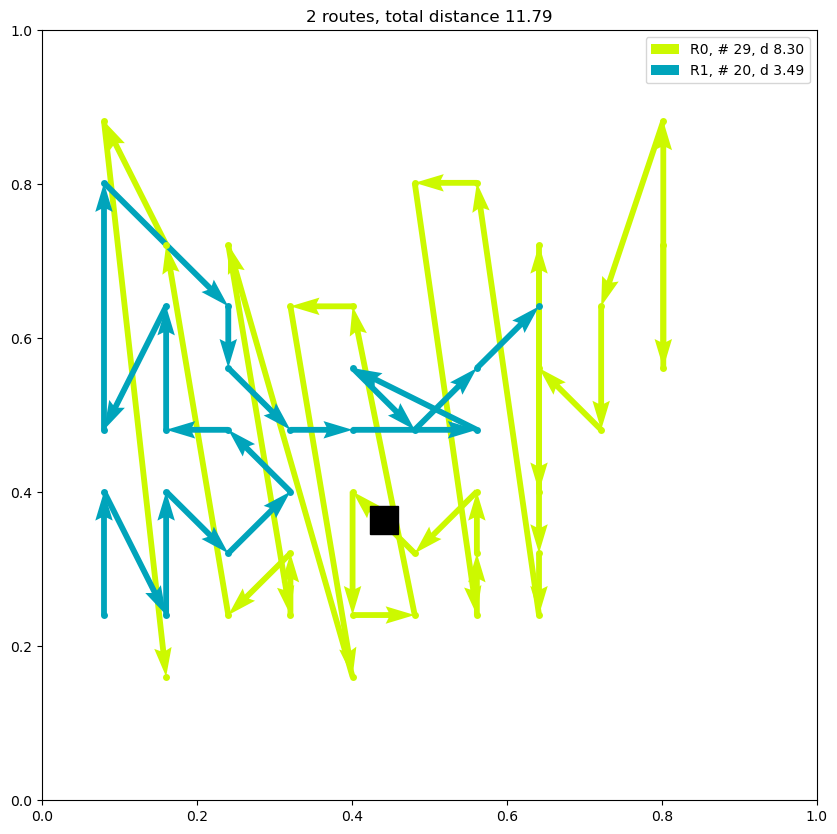

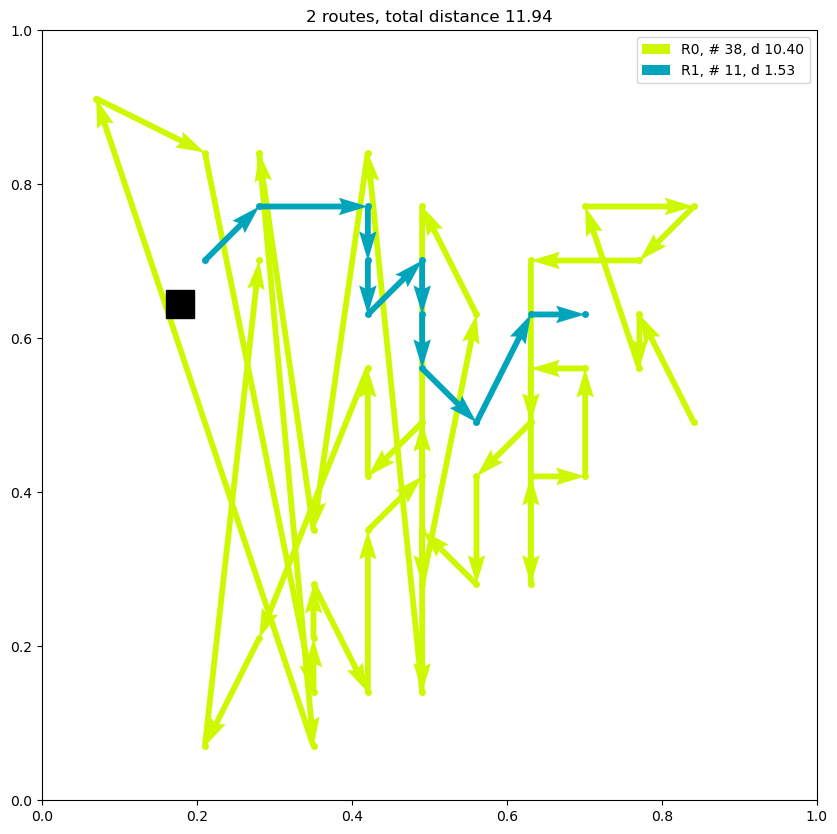

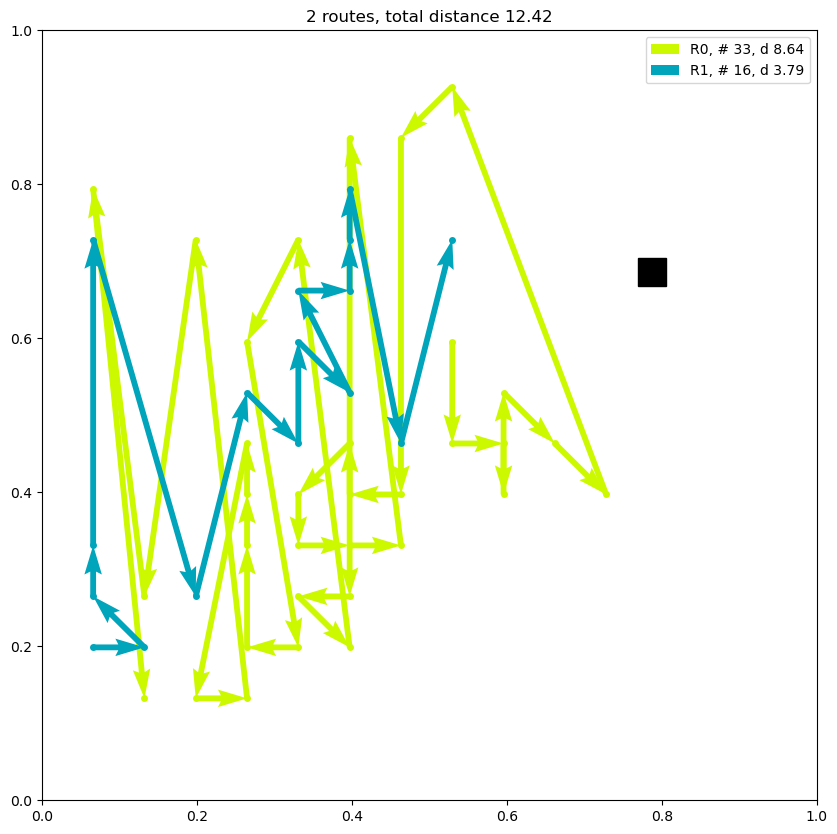

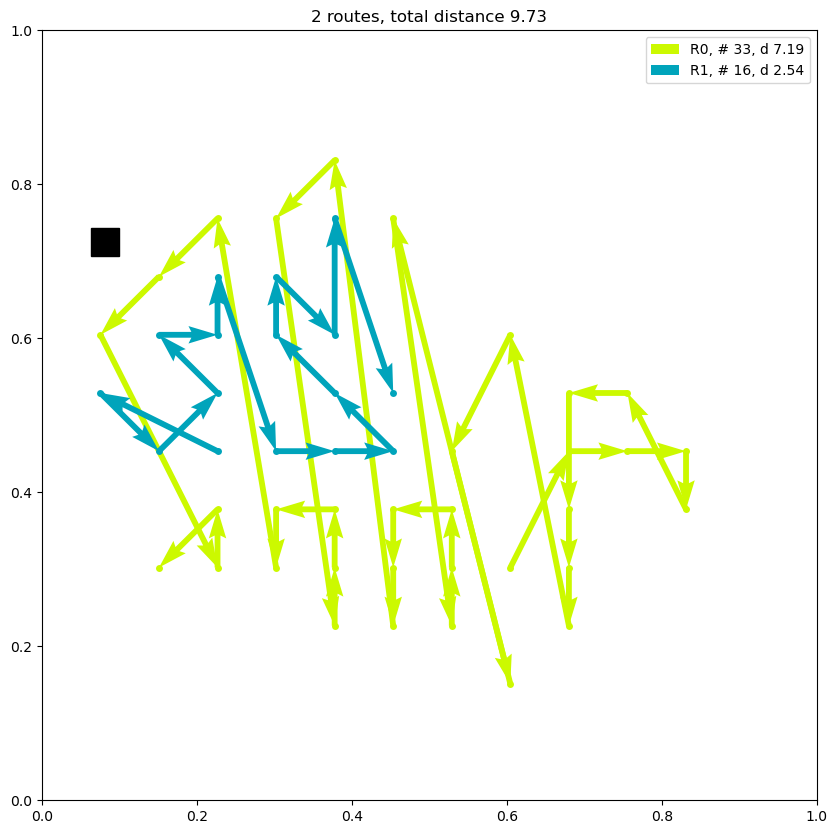

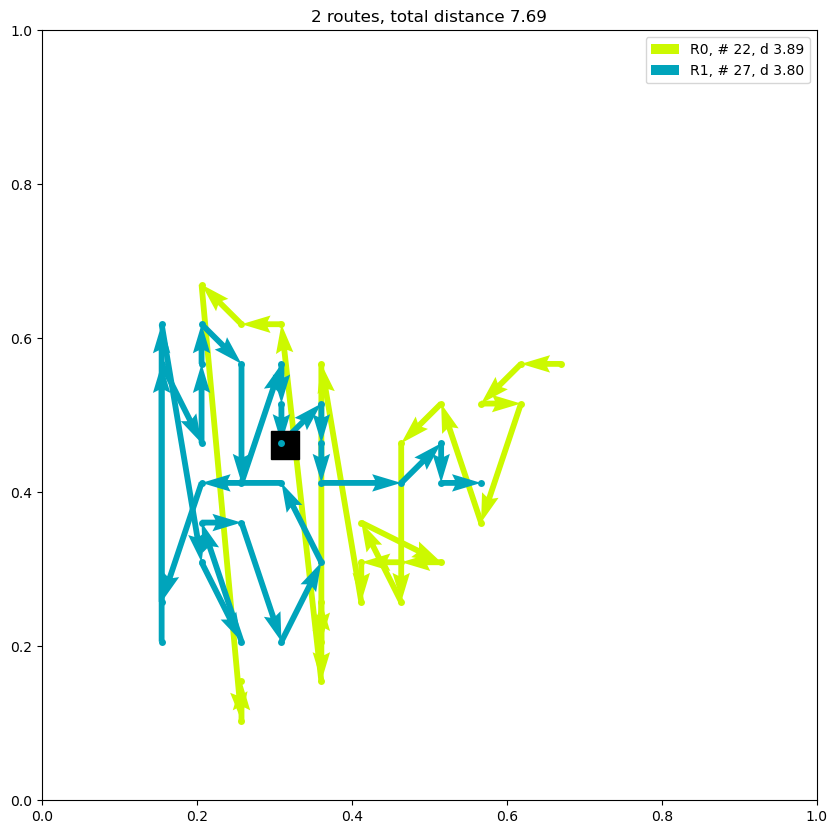

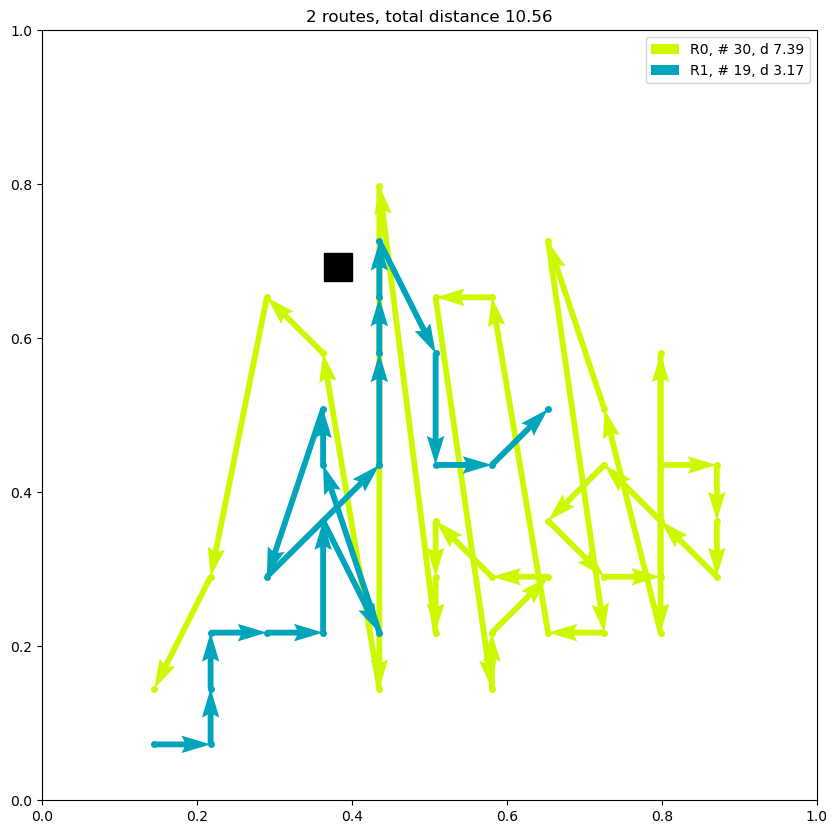

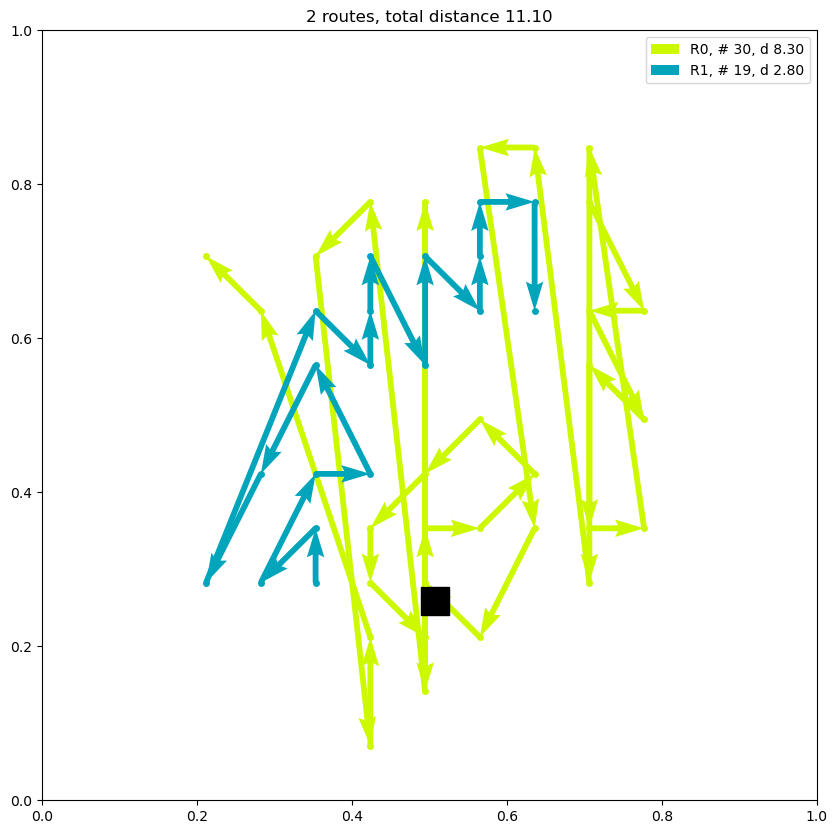

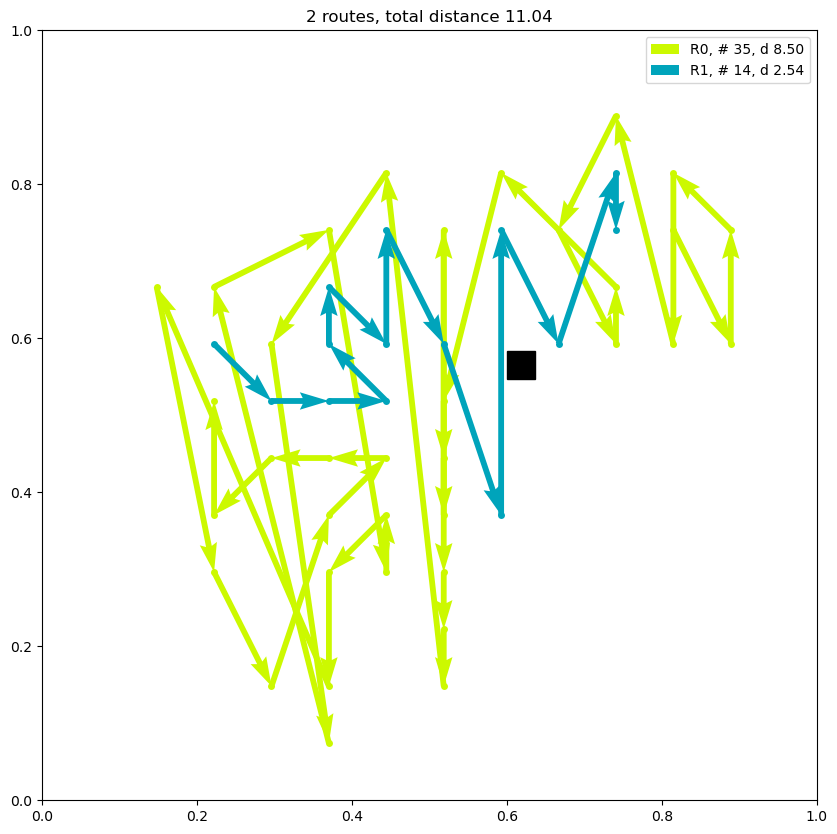

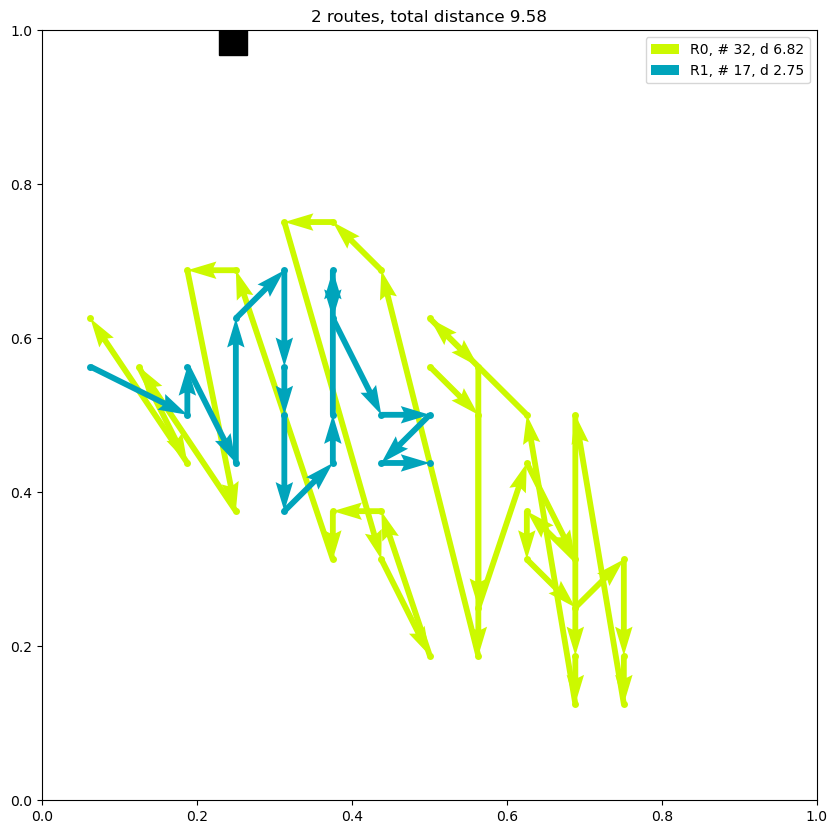

In [10]:
# Need a dataloader to batch instances
dataloader = DataLoader(dataset, batch_size=1000)

# Make var works for dicts
batch = next(iter(dataloader))

tic = time.perf_counter()
# Run the model
model.eval()
model.set_decode_type('greedy')
with torch.no_grad():
    length, log_p, pi = model(batch['loc'], return_pi=True)
tours = pi
toc = time.perf_counter()

#glop valid
# tours = [17, 16, 8, 9, 10, 7, 11, 13, 0, 24, 25, 26, 21, 22, 23, 20, 15, 19, 0, 18, 14, 12, 5, 4, 2, 1, 3, 6]
# HPP valid
# tours = [25, 26, 23, 22, 20, 21, 19, 18, 14, 15, 24, 0, 16, 17, 9, 8, 13, 0, 4, 11, 7, 5, 12, 10, 6, 3, 1, 2]
# Plot the results
all_routes = []
all_route_dist = []
all_total_dist = []
for i, (data, tour) in enumerate(zip(dataset, tours)):
    fig, ax = plt.subplots(figsize=(10, 10))
    routes, route_dist, total_dist = plot_vehicle_routes(data, tour, ax, visualize_demands=False, demand_scale=1, round_demand=True)
    # routes, route_dist, total_dist = solve_vehicle_routes(data, tour, visualize_demands=False, demand_scale=1, round_demand=True)
    all_routes.append(routes)
    all_route_dist.append(route_dist)
    all_total_dist.append(total_dist)
    # fig.savefig(os.path.join('images', 'cvrp_{}.png'.format(i)))

In [ ]:
import pickle
import torch 
# with open('GLOP_routes100.pkl', 'rb') as f:
#     toursGLOP = np.array(pickle.load(f))
# toursGLOP = torch.tensor(toursGLOP[:,0,1:])

with open('HPProutes.pkl', 'rb') as f:
    toursHPP = np.array(pickle.load(f),dtype=np.int64)
toursHPP = torch.tensor(toursHPP)

: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FileNotFoundError: [Errno 2] No such file or directory: 'HPPimages/cvrp_0.png'

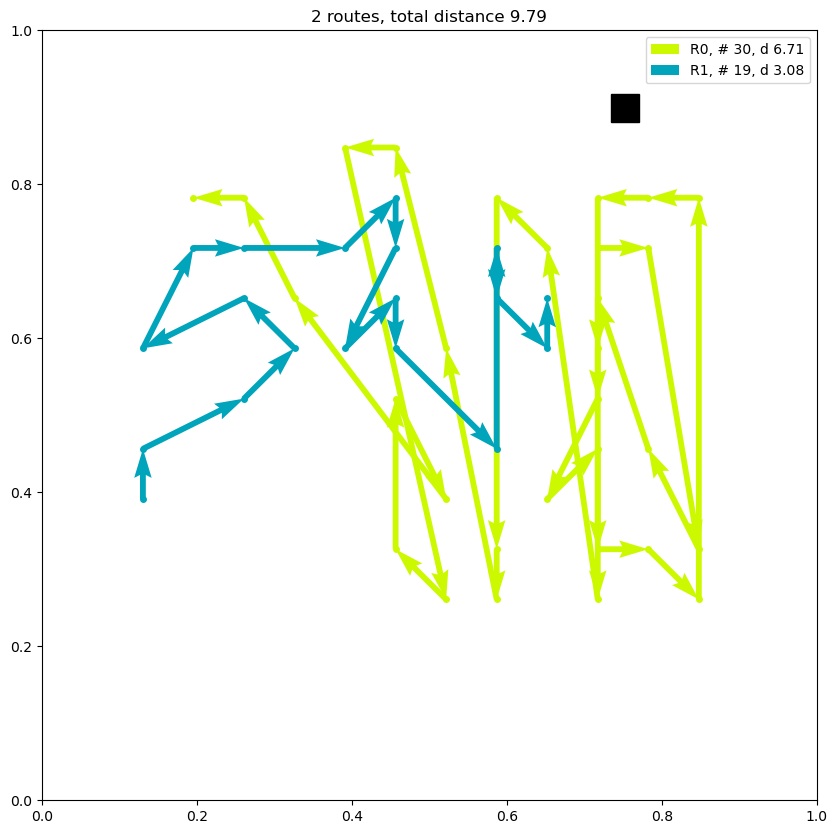

In [11]:

# Plot the results
all_routes = []
all_route_dist = []
all_total_dist = []
for i, (data, tour) in enumerate(zip(dataset, tours)):
    fig, ax = plt.subplots(figsize=(10, 10))
    # routes, route_dist, total_dist = plot_GLOP_routes(data, tour, ax, visualize_demands=False, demand_scale=1, round_demand=True)
    # routes, route_dist, total_dist = plot_HPP_routes(data, tour, ax, visualize_demands=False, demand_scale=1, round_demand=True)

    routes, route_dist, total_dist = plot_vehicle_routes(data, tour, ax, visualize_demands=False, demand_scale=1, round_demand=True)
    # routes, route_dist, total_dist = solve_vehicle_routes(data, tour, visualize_demands=False, demand_scale=1, round_demand=True)
    all_routes.append(routes)
    all_route_dist.append(route_dist)
    all_total_dist.append(total_dist)
    fig.savefig(os.path.join('HPPimages', 'cvrp_{}.png'.format(i)))

In [ ]:

# time = toc - tic

# all_routes = np.array(all_route_dist)
# max_route_dist = np.amax(all_route_dist,axis=-1)
# avg_max_route_dist = np.mean(max_route_dist)

# all_total_dist = np.array(all_total_dist)
# avg_total_dist = np.mean(all_total_dist)

# print(f'vrp_size = {vrp_size}, avg total distance ={avg_total_dist*1000}, avg max route distance={avg_max_route_dist*1000}, time={time}')

: 

: 